In [181]:
# self-define function
from data_cleaning import cleaning_text_MD, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_MD"
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
# nlp
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import spacy 
nlp = spacy.load("en_core_web_lg")
from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/topic_modelling_MD_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])
pd.set_option('display.max_columns', None)
model_df.head()

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
26390,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...
14254,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,323.0,1,1,Mapfre SA,"Yes, I think more or less, yes. Thank you.",Yes I think more or less yes Thank you,NaN
15811,Jesus Amadori,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,274.0,1,0,Mapfre SA,You're going to have to take our word on this ...,You're going to have to take our word on this ...,word speaker past run off triangle quer basis ...
20373,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,332.0,1,0,Mapfre SA,"Oh, that I -- is it?",Oh that I -- is it?,NaN
20372,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,325.0,1,0,Mapfre SA,"Then the -- probably on your third question, t...",Then the -- probably on your third question th...,question volatility realization gain figure fo...


# Tokenize

In [183]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [184]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_4612/458752224.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|██████████| 39288/39288 [06:39<00:00, 98.34it/s] 


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token
26390,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[capital, restructuring, program, today, instr..."
14254,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,323.0,1,1,Mapfre SA,"Yes, I think more or less, yes. Thank you.",Yes I think more or less yes Thank you,nan,[nan]
15811,Jesus Amadori,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,274.0,1,0,Mapfre SA,You're going to have to take our word on this ...,You're going to have to take our word on this ...,word speaker past run off triangle quer basis ...,"[word, speaker, triangle, quer, basis, report,..."
20373,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,332.0,1,0,Mapfre SA,"Oh, that I -- is it?",Oh that I -- is it?,nan,[nan]
20372,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,325.0,1,0,Mapfre SA,"Then the -- probably on your third question, t...",Then the -- probably on your third question th...,question volatility realization gain figure fo...,"[question, volatility, realization, gain, figu..."
...,...,...,...,...,...,...,...,...,...,...,...
4425,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,316.0,0,1,GJENSIDIGE FORSI-,Okay. Understood. So much messages. Thank you.,Okay Unstood So much messages Thank you,message,[message]
4424,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,305.0,0,1,GJENSIDIGE FORSI-,"And sorry, I have to -- why do you say that sh...",And sorry I have to -- why do you say that sho...,term sale,"[term, sale]"
4423,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,270.0,0,1,GJENSIDIGE FORSI-,"Thank you very much, and good morning, gents. ...",Thank you very much and good morning gents I'v...,morning gent question detail one system bit im...,"[morning, gent, question, bit, impact, bit, te..."
13242,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,366.0,1,0,GJENSIDIGE FORSI-,Yes. We got the claims inﬂation. I would start...,Yes We got the claims inﬂation I would st to s...,claim inﬂation course quer inﬂation quer inﬂat...,"[claim, inﬂation, quer, inﬂation, quer, inﬂati..."


# Word-Length Count

In [185]:
# create column for length analysis outcome
model_df['word_count'] = model_df["token"].apply(lambda x: len(x))
model_df['char_count'] = model_df["token"].apply(lambda x: sum(len(word) for word in x))
model_df['sentence_count']  = model_df['paraghrph'].apply(lambda x: len(str(x).split(".")))
model_df['avg_word_length'] = model_df['char_count'] / model_df['word_count']
model_df['avg_sentence_length'] = model_df['word_count'] / model_df['sentence_count'] # note that the word_count is only with noun tokens
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
26390,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[capital, restructuring, program, today, instr...",5,43,7,8.60,0.714286
14254,James Quin,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,323.0,1,1,Mapfre SA,"Yes, I think more or less, yes. Thank you.",Yes I think more or less yes Thank you,nan,[nan],1,3,3,3.00,0.333333
15811,Jesus Amadori,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,274.0,1,0,Mapfre SA,You're going to have to take our word on this ...,You're going to have to take our word on this ...,word speaker past run off triangle quer basis ...,"[word, speaker, triangle, quer, basis, report,...",8,46,3,5.75,2.666667


In [186]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

In [187]:
model_df_original = model_df.copy()

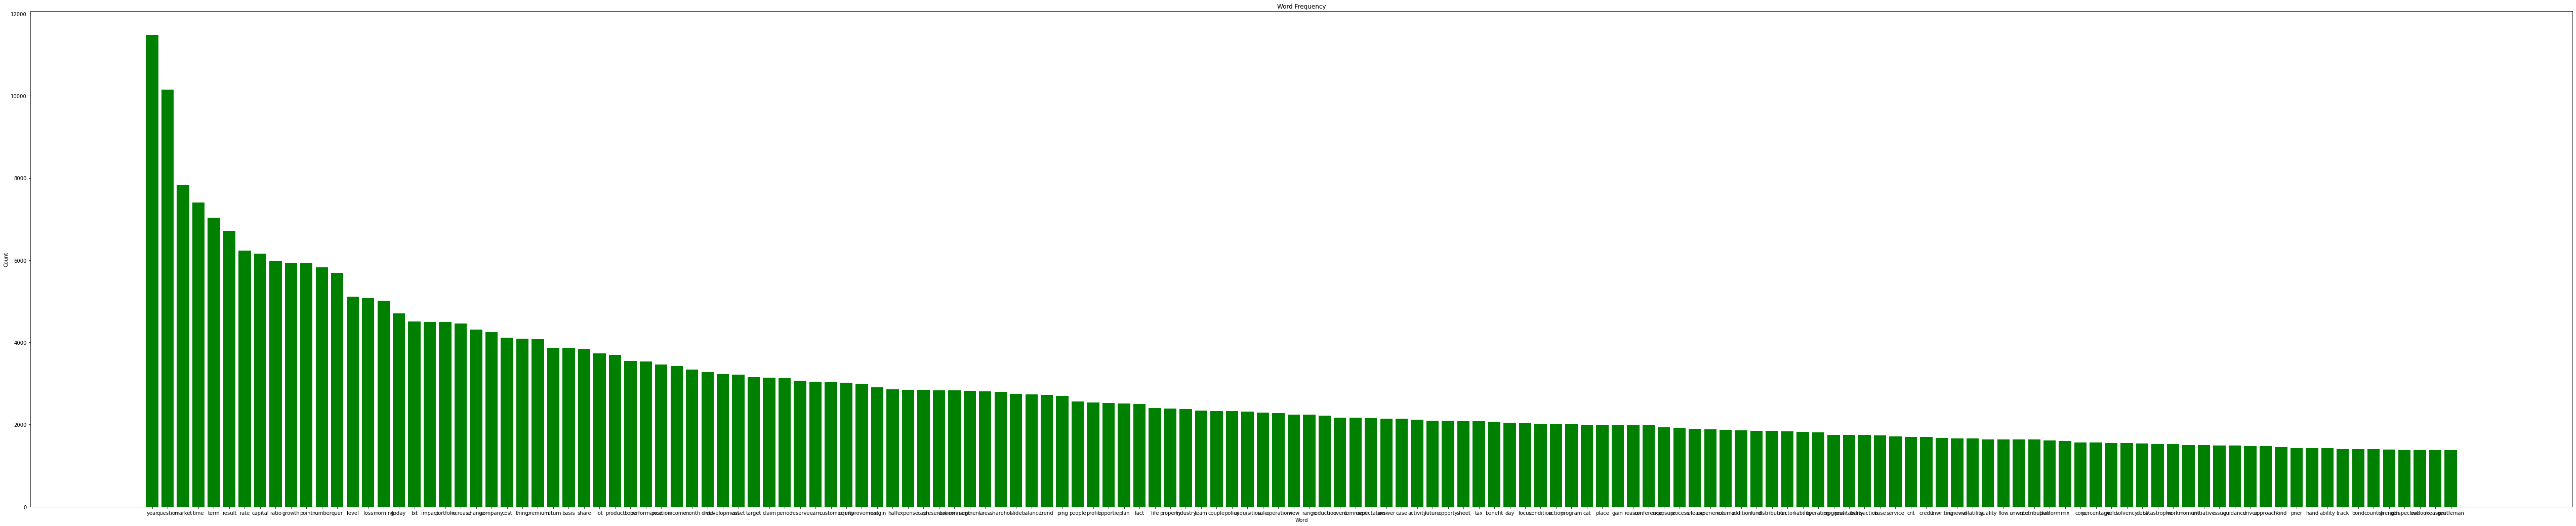

In [189]:
# high frequency words excluding
temp_token = model_df_original['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(90, 18))
plt.bar(word_fr.word[0:150], word_fr.freq[0:150], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()

# remove 50 most frequent words which is known in this context
word_list = word_fr.head(150)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]

model_df['token'] = mdy_list
word_fr

In [191]:
# DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# https://cloud.tencent.com/developer/article/1435976

model_df['date'] = pd.to_datetime(model_df['date'])
model_df['year'] = model_df['date'].apply(lambda x: x.year)
model_df['month'] = model_df['date'].apply(lambda x: x.month)
model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# model_df['date'] to str
model_df['date'] = model_df['date'].astype(str)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,year,month,quater,year_quater
0,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[restructuring, instruction]",5,43,7,8.600000,0.714286,2011,2,1,2011-1
1,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,325.0,1,0,Mapfre SA,"Then the -- probably on your third question, t...",Then the -- probably on your third question th...,question volatility realization gain figure fo...,"[realization, figure, forex, coment]",11,74,5,6.727273,2.200000,2011,2,1,2011-1
2,Nigel Wilson,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,5.0,1,0,LEGAL -,"Thank you. Good afternoon, ladies and gentleme...",Thank you Good afternoon ladies and gentlemen ...,afternoon lady gentleman time call progress mo...,"[afternoon, lady, land, iver, generation, capa...",69,481,36,6.971014,1.916667,2011,2,1,2011-1
3,Nigel Wilson,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,128.0,1,0,LEGAL -,"Thanks, Chris. So in summary, a relatively sma...",Thanks So in summary a relatively small but i...,thank summary transaction material benefit com...,"[summary, material, commitment, phase, coordin...",22,165,7,7.500000,3.142857,2011,2,1,2011-1
4,Nigel Wilson,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,148.0,1,0,LEGAL -,Yes. We envisage that perhaps we'll be able to...,Yes We envisage that perhaps we'll be able to ...,type transaction month financing way transacti...,"[type, financing]",12,72,11,6.000000,1.090909,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21779,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,266.0,1,1,GJENSIDIGE FORSI-,(Question And Answer) Thank you. (Operator Ins...,Question And Answer Thank you Operator Instruc...,question instruction question k,[instruction],3,27,5,9.000000,0.600000,2022,4,2,2022-2
21780,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,1.0,1,1,GJENSIDIGE FORSI-,"Good day, and welcome to the Gjensidige Q1 202...",Good day and welcome to the Gjensidige Q Resu...,day conference time conference,[],4,27,6,6.750000,0.666667,2022,4,2,2022-2
21781,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,316.0,0,1,GJENSIDIGE FORSI-,Okay. Understood. So much messages. Thank you.,Okay Unstood So much messages Thank you,message,[message],1,7,5,7.000000,0.200000,2022,4,2,2022-2
21782,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,270.0,0,1,GJENSIDIGE FORSI-,"Thank you very much, and good morning, gents. ...",Thank you very much and good morning gents I'v...,morning gent question detail one system bit im...,"[gent, beneﬁts, game, changer, think, lag, ope...",41,224,13,5.463415,3.153846,2022,4,2,2022-2


In [192]:
test_df = model_df.copy()
date_list = test_df['year_quater'].unique().tolist()
# if the date_list == test_df['date'], append to the dtm_list
dtm_token_list = []
dtm_token_df = []
dtm_df = pd.DataFrame()
for date in date_list:
    tmp_df = test_df[test_df['year_quater']==date]

    tmp_token_list = tmp_df['token'].to_list()
    for i in tmp_token_list:
        for k in i:
            dtm_token_list.append(k)
    dtm_token_df.append(dtm_token_list)
    dtm_token_list = []
    dtm_df['year_quater'] = date_list
dtm_df['token'] = dtm_token_df
dtm_df

,year_quater,token
0,2011-1,"[restructuring, instruction, realization, figu..."
1,2011-2,"[corner, goodwill, reporting, form, ing, goodw..."
2,2011-3,"[afternoon, lady, overview, financial, figure,..."
3,2011-4,"[overview, motor, pressure, tariff, dec, cover..."
4,2012-1,"[record, blowout, insurer, reinsurer, adequacy..."
5,2012-2,"[file, disclosure, respect, statement, regard,..."
6,2012-3,"[saving, mind, negative, disclosure, guarantee..."
7,2012-4,"[topic, cycle, competition, peer, barrier, ent..."
8,2013-1,"[afternoon, lady, proposal, king, rule, pensio..."
9,2013-2,"[player, leas, accit, sense, sense, accit, sor..."


# Docs_tokens

In [193]:
# https://github.com/bab2min/tomotopy
# https://bab2min.github.io/tomotopy/v0.12.3/en/#tomotopy.DTModel
# https://notebook.community/pombredanne/gensim/docs/notebooks/ldaseqmodel

In [194]:
# recrate again for getting the docs_tokens
temp_token_dtm = dtm_df['token'] # .apply(remove_brackets)
docs_tokens_dtm = []
for i in temp_token_dtm:
    docs_tokens_dtm.append(i)
len(docs_tokens_dtm)

46

# docs_phrased

In [195]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram_dtm = Phrases(                              
    docs_tokens_dtm,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram_dtm = Phrases(                             
    bigram_dtm[docs_tokens_dtm],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased_dtm = [trigram_dtm[bigram_dtm[line]] for line in docs_tokens_dtm]
len(docs_tokens_dtm)

46

# corpus

In [196]:
corpus_dtm = tp.utils.Corpus() 
for i in range(len(docs_tokens_dtm)):
    # corpus_dtm.add_doc with timepoint
    corpus_dtm.add_doc(words=docs_tokens_dtm[i], timepoint=i) # dtm_df['date'][i]
print(len(corpus_dtm))

46


# model base on the topic number we select (without time series)

In [197]:
best_mdl = tp.DTModel(
    # tw= TermWeight.ONE, # term weighting scheme in TermWeight. The default value is TermWeight.ONE
    # min_cf=0, # minimum collection frequency of words
    # min_df=0, # minimum document frequency of words
    # rm_top=0, # remove top frequency words
    # transform=None, # transformation of the corpus
    k=22,
    t = len(dtm_df),
    corpus=corpus_dtm,
    seed = 1
    )


for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -8.880421488086558
Iteration: 10	Log-likelihood: -8.751533989840222
Iteration: 20	Log-likelihood: -8.178969151973394
Iteration: 30	Log-likelihood: -7.6317586641247654
Iteration: 40	Log-likelihood: -7.153842880576083
Iteration: 50	Log-likelihood: -6.7570776588076455
Iteration: 60	Log-likelihood: -6.442757129793275
Iteration: 70	Log-likelihood: -6.243148640619047
Iteration: 80	Log-likelihood: -6.123770750246936
Iteration: 90	Log-likelihood: -5.999675291007783


In [198]:
wt = pd.DataFrame()
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，with required argument 'timepoint' (pos 2)
for k in range(best_mdl.k):
    words, probs, timepoints = [], [], []
    for t in range(len(corpus_dtm)):
        for word, prob in best_mdl.get_topic_words(k ,timepoint=t):
            timepoints.append(t)
            words.append(word)
            probs.append(prob)
        tmp = pd.DataFrame(
            {
                "word": words,
                "prob": np.round(probs, 3),
                "timepoint": timepoints,
                "k": np.repeat(k, len(words)),
                "sort": np.arange(0, len(words)),
            }
        )
    words, probs, timepoints = [], [], []
    wt = wt.append(tmp)
    del tmp

wt

,word,prob,timepoint,k,sort
0,ehquake,0.007,0,0,0
1,comparison,0.006,0,0,1
2,ﬁgure,0.006,0,0,2
3,scheme,0.006,0,0,3
4,datum,0.006,0,0,4
...,...,...,...,...,...
455,agreement,0.022,45,21,455
456,brand,0.022,45,21,456
457,building,0.022,45,21,457
458,discount,0.022,45,21,458


In [243]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,timepoint
0,0.040404,0.046560,0.056169,0.041455,0.040254,0.047761,0.042356,0.042807,0.032146,0.049263,0.050464,0.044458,0.045960,0.052116,0.036651,0.043557,0.051365,0.049263,0.042356,0.055569,0.048962,0.040104,0
1,0.043778,0.047781,0.039775,0.056931,0.050641,0.039203,0.035771,0.048925,0.038631,0.044064,0.044636,0.050926,0.054072,0.046637,0.032054,0.052928,0.044064,0.043492,0.049783,0.041204,0.048067,0.046637,1
2,0.038995,0.037023,0.053707,0.046578,0.050067,0.042483,0.035506,0.055224,0.039146,0.040815,0.050218,0.041270,0.031563,0.052342,0.047033,0.045517,0.050825,0.053100,0.041270,0.052797,0.049763,0.044758,2
3,0.050989,0.040614,0.047022,0.046412,0.041834,0.050684,0.040614,0.045496,0.048548,0.058312,0.042140,0.050378,0.036342,0.056786,0.042750,0.043970,0.048242,0.036037,0.037257,0.038478,0.047632,0.049463,3
4,0.074337,0.053401,0.033511,0.041493,0.038615,0.050784,0.033250,0.038745,0.044110,0.037960,0.058766,0.041362,0.047382,0.063346,0.042671,0.038615,0.044895,0.045157,0.035997,0.035997,0.061121,0.038484,4
5,0.040941,0.049424,0.040692,0.037947,0.053415,0.037448,0.043186,0.043685,0.053665,0.036949,0.044434,0.046679,0.040692,0.063645,0.035452,0.044933,0.039195,0.046679,0.049174,0.054663,0.050671,0.046430,5
6,0.050467,0.046716,0.042028,0.042590,0.047841,0.046529,0.041653,0.043340,0.040527,0.043716,0.050467,0.036026,0.046154,0.043340,0.046716,0.043528,0.043528,0.053468,0.055718,0.037527,0.041840,0.056281,6
7,0.042165,0.049094,0.043320,0.049863,0.064682,0.044475,0.035622,0.054482,0.039664,0.051788,0.048901,0.045052,0.037932,0.038316,0.054097,0.045629,0.046014,0.041011,0.045629,0.041396,0.036777,0.044090,7
8,0.053705,0.116614,0.025321,0.039430,0.051630,0.031131,0.046484,0.038019,0.042833,0.043497,0.041671,0.047563,0.032459,0.040675,0.037438,0.029305,0.039015,0.043165,0.043331,0.042999,0.053954,0.059763,8
9,0.043721,0.053002,0.035790,0.047096,0.058739,0.038490,0.035453,0.050133,0.057389,0.037815,0.051146,0.038321,0.043890,0.028197,0.044059,0.034103,0.040684,0.066333,0.062114,0.042877,0.043215,0.047433,9


In [244]:
# save td to csv
td.to_csv('./main_df_output/td_seq.csv', index=False) 
wt.to_csv('./main_df_output/wt_seq.csv', index=False)

In [288]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=td.columns,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='All Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

# save the figure to html
fig.write_html('./main_df_output/MD_topic_plot.html')

# During the middle of time 

In [286]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=['topic_2', 'topic_6', 'topic_9', 'topic_13', 'topic_14', 'topic_15'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Middle Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [117]:
# td_timep38 = td[td['timepoint']==38]
# # sort the topic_13 inside td_tp38
# td_timep38 = td_timep38.sort_values(by=["topic_22"], ascending=False)
# td_timep38.head(10)

In [281]:
# - 2 > timep 22, 21
# - 6 > timep 18, 19, 20
# - 9 > timep 29, 25
# - 13 > timep 16
# - 14 > timep 15, 23, 17
# - 15 > timep 24

# topic_2
topic_2 = wt[wt['k']==1] # start with 0
# select timepoint
topic_2_22 = topic_2[topic_2['timepoint']==22]
topic_2_21 = topic_2[topic_2['timepoint']==21]
# concat
topic_2_concate = pd.concat([topic_2_22, topic_2_21], ignore_index=True)
topic_2_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_6
topic_6 = wt[wt['k']==5] # start with 0
# select timepoint
topic_6_22 = topic_6[topic_6['timepoint']==22]
topic_6_21 = topic_6[topic_6['timepoint']==21]
# concat
topic_6_concate = pd.concat([topic_6_22, topic_6_22], ignore_index=True)
topic_6_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_9
topic_9= wt[wt['k']==8] # start with 0
# select timepoint
topic_9_29 = topic_9[topic_9['timepoint']==29]
topic_9_25 = topic_9[topic_9['timepoint']==25]
# concat 
topic_9_concat = pd.concat([topic_9_29, topic_9_25], ignore_index=True)
topic_9_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_13
topic_13= wt[wt['k']==12] # start with 0
# select timepoint
topic_13_16 = topic_13[topic_13['timepoint']==16]
# concat
topic_13_concate = topic_13_16.copy()
topic_13_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_14
topic_14= wt[wt['k']==13] # start with 0
# select timepoint
topic_14_15 = topic_14[topic_14['timepoint']==15]
topic_14_23 = topic_14[topic_14['timepoint']==23]
topic_14_17 = topic_14[topic_14['timepoint']==17]
# concat 
topic_14_concat = pd.concat([topic_14_15, topic_14_23, topic_14_17], ignore_index=True)
topic_14_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_15
topic_15 = wt[wt['k']==14] # start with 0
# select timepoint
topic_15_24 = topic_15[topic_15['timepoint']==24]
# concat
topic_15_concate = topic_15_24.copy()
topic_15_concate.sort_values(by='prob', ascending=False, inplace=True)

In [282]:
# concat
topic_all_middle = pd.concat([topic_2_concate, topic_6_concate, topic_9_concat, topic_13_concate, topic_14_concat, topic_15_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_middle = topic_all_middle.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_middle.sort_values(by='prob', ascending=False, inplace=True)
topic_all_middle.T

,51,47,24,26,33,18,2,4,6,50,48,46,5,25,0,27,37,1,7,49,23,43,52,45,36,41,42,44,16,9,8,3,35,15,21,30,19,20,28,13,22,39,34,14,32,17,11,10,12,29,31,38,40
word,variability,suﬃcient,guarantee,inflow,protection,duration,agent,assumption,board,treaty,synergy,structure,auto,health,accit,meeting,report,agency,brand,technology,generation,solution,weather,statement,relationship,scheme,sensitivity,specialty,decrease,channel,capability,annuity,rating,deal,figure,motor,employee,fee,mm,confit,force,revenue,proﬁt,currency,pension,dollar,commission,class,compensation,mortgage,movement,retention,save
prob,0.167,0.167,0.167,0.006,0.006,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.004667,0.0045,0.0045,0.004,0.004,0.004,0.003667,0.0035,0.0035,0.0035,0.003333,0.0032,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002875,0.002667,0.002571,0.002333,0.002,0.002,0.002,0.002,0.00175,0.00175,0.0015,0.00125


# early time of the common topics

In [285]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=['topic_1', 'topic_10', 'topic_11', 'topic_12', 'topic_19', 'topic_21'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Early Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [264]:
# - 1 > timep 4, 45
# - 21 > timep 45, 4
# - 11 > timep 4, 45
# - 12 > timep 44, 1
# - 10 > timep 11, 45
# - 19 > timep 9, 12

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_4 = topic_13[topic_13['timepoint']==4]
topic_1_45 = topic_13[topic_13['timepoint']==45]
# concat
topic_1_concate = pd.concat([topic_1_4, topic_1_45], ignore_index=True)
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_10
topic_10 = wt[wt['k']==9] # start with 0
# select timepoint
topic_10_11 = topic_10[topic_10['timepoint']==11]
topic_10_45 = topic_10[topic_10['timepoint']==45]
# concat 
topic_10_concate = pd.concat([topic_10_11, topic_10_45], ignore_index=True)
topic_10_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_11
topic_11= wt[wt['k']==10] # start with 0
# select timepoint
topic_11_4 = topic_11[topic_11['timepoint']==4]
topic_11_45 = topic_11[topic_11['timepoint']==45]
# concat
topic_11_concate = pd.concat([topic_11_4, topic_11_45], ignore_index=True)
topic_11_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_12
topic_12= wt[wt['k']==11] # start with 0
# select timepoint
topic_12_44 = topic_12[topic_12['timepoint']==44]
topic_12_1 = topic_12[topic_12['timepoint']==1]
# concat 
topic_12_concat = pd.concat([topic_12_44, topic_12_1], ignore_index=True)
topic_12_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_19
topic_19 = wt[wt['k']==18] # start with 0
# select timepoint
topic_19_9 = topic_19[topic_19['timepoint']==9]
topic_19_12 = topic_19[topic_19['timepoint']==12]
# concat 
topic_19_concat = pd.concat([topic_19_9, topic_19_12], ignore_index=True)
topic_19_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_21
topic_21 = wt[wt['k']==20] # start with 0
# select timepoint
topic_21_45 = topic_21[topic_21['timepoint']==45]
topic_21_4 = topic_21[topic_21['timepoint']==4]
# concat 
topic_21_concat = pd.concat([topic_21_45, topic_21_4], ignore_index=True)
topic_21_concat.sort_values(by='prob', ascending=False, inplace=True)

In [266]:
# concat all together
topic_all_early = pd.concat([topic_1_concate, topic_10_concate, topic_11_concate, topic_12_concat, topic_19_concat, topic_21_concat], ignore_index=True)

# groupby word and get the average of prob
topic_all_early = topic_all_early.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_early.sort_values(by='prob', ascending=False, inplace=True)
topic_all_early.T

,79,77,25,18,58,28,39,43,62,21,40,9,47,54,56,60,63,45,70,83,19,8,36,55,52,76,1,30,71,12,41,35,67,64,74,78,10,20,34,48,82,81,57,24,72,49,31,26,29,32,4,68,5,65,16,22,15,59,50,80,73,75,0,61,23,2,3,6,7,11,13,14,17,27,53,33,38,44,46,42,69,66,51,37
word,wage,synergy,ehquake,destruction,player,estate,instance,inﬂation,proﬁt,diﬀerent,instrument,building,majority,overview,oﬀset,procurement,proﬁtability,ium,sensitivity,yen,discount,beneﬁts,housing,oﬀ,motor,structure,adjustment,eﬀect,situation,capacity,integration,health,retention,qbe,stock,traction,buyback,discussion,gbpb,material,winter,website,pension,efficiency,statement,meeting,fall,element,extent,financial,annuity,revenue,assumption,relationship,crop,dollar,crisis,problem,mind,weather,step,storm,accit,protection,duration,adtage,agent,auto,bank,capability,class,competitor,decrease,energy,movement,force,inflow,item,load,investor,save,respect,money,impairment
prob,0.039,0.032,0.02,0.019,0.019,0.019,0.019,0.019,0.0165,0.016333,0.016,0.016,0.016,0.016,0.016,0.015,0.0145,0.014,0.014,0.014,0.014,0.014,0.013,0.013,0.013,0.0125,0.011,0.0105,0.0105,0.009,0.009,0.0085,0.008,0.008,0.0075,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.0055,0.005333,0.005333,0.005,0.005,0.005,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.0035,0.0035,0.0035,0.003


In [ ]:
ehquake, destruction, estate, instrument, building, yen, housing

# recent time of the common topics

In [284]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=['topic_3', 'topic_4', 'topic_5', 'topic_17', 'topic_22'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Recent Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [272]:
# - 5 > timep 43
# - 17 > timep 40, 36, 42
# - 4 > timep 34, 35, 41
# - 3 > timep 39, 37, 30
# - 22 > timep 38, 33

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_39 = topic_3[topic_3['timepoint']==39]
topic_3_37 = topic_3[topic_3['timepoint']==37]
topic_3_30 = topic_3[topic_3['timepoint']==30]
# concat 
topic_3_concat = pd.concat([topic_3_39, topic_3_37, topic_3_30], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_34 = topic_4[topic_4['timepoint']==34]
topic_4_35 = topic_4[topic_4['timepoint']==35]
topic_4_41 = topic_4[topic_4['timepoint']==41]
# concat 
topic_4_concat = pd.concat([topic_4_34, topic_4_35, topic_4_41], ignore_index=True)
topic_4_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5 = wt[wt['k']==4] # start with 0
# select timepoint
topic_5_43 = topic_21[topic_21['timepoint']==43]
# concat 
topic_5_concat = topic_5_43.copy()
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_17
topic_17 = wt[wt['k']==16] # start with 0
# select timepoint
topic_17_40 = topic_17[topic_17['timepoint']==40]
topic_17_36 = topic_17[topic_17['timepoint']==36]
topic_17_4 = topic_17[topic_17['timepoint']==4]
# concat 
topic_17_concat = pd.concat([topic_17_40, topic_17_36, topic_17_4], ignore_index=True)
topic_17_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_22
topic_22= wt[wt['k']==21] # start with 0
# select timepoint
topic_22_38 = topic_22[topic_22['timepoint']==38]
topic_22_33 = topic_22[topic_22['timepoint']==33]
# concat 
topic_22_concat = pd.concat([topic_22_38, topic_22_33], ignore_index=True)
topic_22_concat.sort_values(by='prob', ascending=False, inplace=True)


In [289]:
# concat all together
topic_all_recently = pd.concat([topic_3_concat, topic_4_concat, topic_5_concat, topic_17_concat, topic_22_concat], ignore_index=True)
# groupby word and get the average of prob
topic_all_recently = topic_all_recently.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_recently.sort_values(by='prob', ascending=False, inplace=True)
topic_all_recently.T

,68,60,64,12,29,15,65,54,40,13,52,18,14,31,67,66,48,38,25,11,36,28,33,4,23,10,50,21,49,41,61,53,44,24,8,5,47,55,56,51,46,58,59,62,57,0,45,43,2,3,6,7,9,17,20,34,1,35,39,42,32,16,30,19,63,37,22,26,27
word,ﬂex,tophe,uncertainty,coverage,interruption,damage,virus,state,pandemic,crisis,situation,ehquake,crop,lockdown,worker,weather,revenue,movement,generation,contract,money,injury,member,annuity,force,commission,scale,exclusion,save,pension,total,solution,provision,frequency,casualty,assumption,retention,statement,stock,ship,report,synergy,technology,transformation,structure,accit,proﬁt,proposition,agreement,ambition,brand,capability,channel,decision,estimate,mm,adjustment,momentum,organization,priority,meeting,datum,investor,employee,travel,mortgage,fee,health,inflation
prob,0.167,0.167,0.0445,0.016,0.01,0.01,0.009,0.007,0.0062,0.006,0.006,0.006,0.006,0.005,0.005,0.005,0.004545,0.0045,0.004143,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003667,0.0035,0.0035,0.0035,0.003333,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.0025,0.00225,0.002,0.002,0.002,0.002,0.002,0.0015,0.0015


In [290]:
# topic_all_recently to csv
topic_all_recently.to_csv('./main_df_output/MD_topic_all_recently.csv')
topic_all_early.to_csv('./main_df_output/MD_topic_all_early.csv')
topic_all_middle.to_csv('./main_df_output/MD_topic_all_middle.csv')

# See what time is it 

In [ ]:
# # td sort by timepoint
# td = td.sort_values(by=["timepoint"])
# # create dtm_df['timepoint'] from 0 to 133
# dtm_df['timepoint'] = np.arange(0, len(dtm_df))
# dtm_df
# # merge td and dtm_df
# td = pd.merge(td, dtm_df, on="timepoint")
# td.head(3)